# Advanced Lane Finding Project


## The goals / steps of this project are the following:

1 Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

2 Apply a distortion correction to raw images.

3 Use color transforms, gradients, etc., to create a thresholded binary image.

4 Apply a perspective transform to rectify binary image ("birds-eye view").

5 Detect lane pixels and fit to find the lane boundary.

6 Determine the curvature of the lane and vehicle position with respect to center.

7 Warp the detected lane boundaries back onto the original image.

8 Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import

In [1]:
import os
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.image as mpimg
%matplotlib inline       
# matplotlib inline is necessary to output an image in Jupyter notebook
nx = 9
ny = 6

## Input for text plotting on graphs

In [2]:
font1                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText1 = (400,50)
bottomLeftCornerOfText2 = (400,100)
bottomLeftCornerOfText3 = (400,150)
bottomLeftCornerOfText4 = (400,200)
fontScale1              = 1
fontColor1              = (255,255,255)
lineType1               = 2

## Calibrate Camera Function

In [3]:
def calibrate_camera():
    objp = np.zeros((9 * 6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # 1. Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    #images = glob.glob('./camera_cal/calibration*.jpg')
    
    # 2. Take all images from the camera_cal folder to undistort
    os.listdir("camera_cal/")
    for filename in os.listdir("camera_cal/"):
        #  2.1 Reading files for filename 
        img = mpimg.imread("camera_cal/" + filename)

    # Step through the list and search for chessboard corners
    #for i, fname in enumerate(images):    
    #img = cv2.imread(fname)
        
        #  2.2 gray scale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #  2.3 Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        #  2.4 If found, add (append) object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #  2.4.1 Draw the corners
            corner = cv2.drawChessboardCorners(img, (9, 6), corners, ret) 
            mpimg.imsave("camera_corner/" + filename, corner)
        
        # 2.5 Camera calibration, given object points, image points, and the shape of the grayscale image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # 3. Plot the result, the images.   
        #plt.imshow(corner)
    return ret, mtx, dist, rvecs, tvecs

## Visualize Corners detected

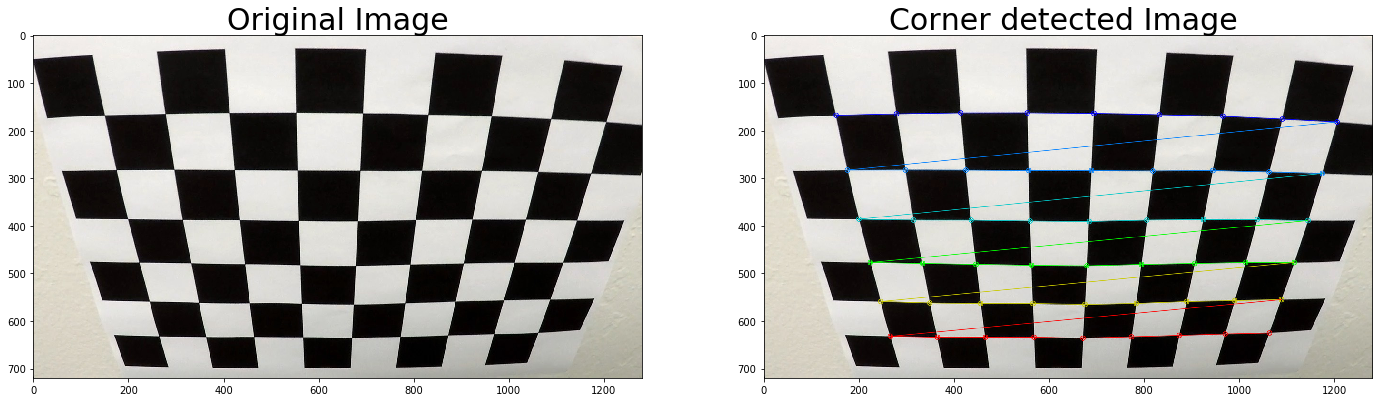

In [4]:
# 1. take an images from the camera_cal folder to visualize 
image = mpimg.imread('./camera_cal/calibration2.jpg')
# 2. take an images from the camera_cal folder to visualize 
corner = mpimg.imread('./camera_corner/calibration2.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.set_title('Original Image', fontsize=30)
ax1.imshow(image)
ax2.set_title('Corner detected Image ', fontsize=30)
ax2.imshow(corner)

## Chessboard Images

In [5]:
# 1. Call the calibration camera function
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

# Save point in pickle for later use
pickle.dump(mtx, open( "mtx.p", "wb" ))
pickle.dump(dist, open( "dist.p", "wb" ))


# 2. take all images from the camera_cal folder to undistort
os.listdir("camera_cal/")
for filename in os.listdir("camera_cal/"):
    # 2.1 Reading files for filename 
    image = mpimg.imread("camera_cal/" + filename)
    # 2.2 call the undistort function
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    # 2.3 save all images to the folder camera_undistort
    mpimg.imsave('./camera_corner/camera_undistort/' + filename, undistort_img)
    
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(undistort_img)
#ax2.set_title('Undistorted Image', fontsize=30)

## Visualize Undistorted Chessboard Image

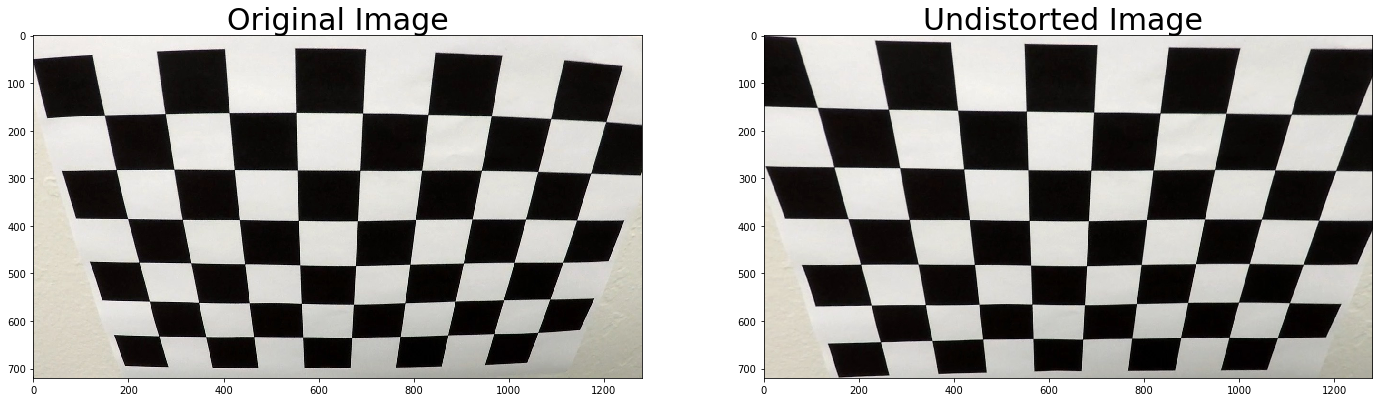

In [6]:
# 1. take an images from the camera_cal folder to visualize 
image = mpimg.imread('./camera_cal/calibration2.jpg')
# 2. take an images from the camera_cal folder to visualize 
undistort = mpimg.imread('./camera_corner/camera_undistort/calibration2.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.set_title('Original Image', fontsize=30)
ax1.imshow(image)
ax2.set_title('Undistorted Image ', fontsize=30)
ax2.imshow(undistort)

## Sobel Threshold Function

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel= 3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # as we are doing mpimg while reading image
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # If we were rading image as cv2.imread('signs_vehicles_xygrad.png')
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel) # taking deravative wrt x
        abs_sobel = np.absolute(sobelx)
    
    if orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel) # taking derivative wrt y
        abs_sobel = np.absolute(sobely)
    
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    #thresh_min = 20
    #thresh_max = 100
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sbinary, cmap='gray')        
    binary_output = sbinary        
    # 6) Return this mask as your binary_output image
    return binary_output

## Magnitude of the Gradient Function

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    abs_sobelxy = np.sqrt((sobel_x * sobel_x) + (sobel_y * sobel_y))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    #plt.imshow(sxybinary, cmap='gray')
    
    # 6) Return this mask as your binary_output image
    binary_output = sxybinary # Remove this line
    return binary_output

## Direction Threshold Function

In [9]:
def dir_threshold(img, sobel_kernel=9, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    dirbin_output = np.zeros_like(dir_gradient)
    dirbin_output[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    return dirbin_output

## HLS Color Threshold Function

In [131]:
def hls_select(img, thresh):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output_s = np.zeros_like(S)
    binary_output_s[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Apply a threshold to the L channel
    binary_output_l = np.zeros_like(L)
    binary_output_l[(L > thresh[0]) & (L <= thresh[1])] = 1
    # 4) Apply a threshold to the H channel
    binary_output_h = np.zeros_like(H)
    binary_output_h[(H > thresh[0]) & (H <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output_s, binary_output_l, binary_output_h

## HSV Color Thershold Function

In [132]:
def hsv_select(img, thresh):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output_s = np.zeros_like(S)
    binary_output_s[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Apply a threshold to the L channel
    binary_output_v = np.zeros_like(V)
    binary_output_v[(V > thresh[0]) & (V <= thresh[1])] = 1
    # 4) Apply a threshold to the H channel
    binary_output_h = np.zeros_like(H)
    binary_output_h[(H > thresh[0]) & (H <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output_v

## Perspective Transform Function

In [12]:
def corners_unwarp(img):
    # 1. Pass in your image into this function 
    # 2. define offset for dst points
    #offset = 100 
    # 3. Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 4. Grab image shape
    img_size = (img.shape[1], img.shape[0])
    
    # 5. define 4 source points src = np.float32([[,],[,],[,],[,]])
    #Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    #One especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    #We recommend using the automatic detection of corners in your code
    
    bottom_left = [270,720]
    bottom_right = [1127, 720]
    top_left = [620, 450]#565#550
    top_right = [720, 450]#750#735

    src = np.float32([bottom_left,bottom_right,top_right,top_left])

    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 0]
    top_right = [920, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    
    # 7. use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
            
    # 8. use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv, src, dst

## Finding Lanes - Histogram Function

In [13]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    #histogram = np.sum(img[:,:,0],axis = 0) 
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    
    return histogram

## Finding Lane - Implement Sliding Windows and Fit a Polynomial Function

In [220]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

## Finding Lane - Search around poly Function

In [221]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]#pixel points
    out_img[righty, rightx] = [0, 0, 255]#pixel points

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

## Measuring Curvature in Pixels

In [16]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    
    #Calculates the curvature of polynomial functions in pixels.

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # determining the x intercept left and right lane when y value is maximum
    x_left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    #determing location of car per our calculation
    car_location_pixel = x_left_eval+(x_right_eval - x_left_eval) / 2
    
    
    return left_curverad, right_curverad, car_location_pixel

## Measuring curvature of the lanes and Vehicle position wrt center

In [17]:
def measure_curvature_realm(binary_warped,ym_per_pix,xm_per_pix, left_fit, right_fit):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(plot_y)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # determining the x intercept left and right lane when y value is maximum
    x_left_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    x_right_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    #determing location of car per our calculation
    car_location_m = x_left_eval+(x_right_eval - x_left_eval) / 2
    
    # 2.23.2 Calculate distance from center
    center_car = binary_warped.shape[1]/2
    off_center = (center_car - car_location_m) * xm_per_pix

    return left_curverad, right_curverad, off_center

## Test Images and Create Outputs - Pipeline

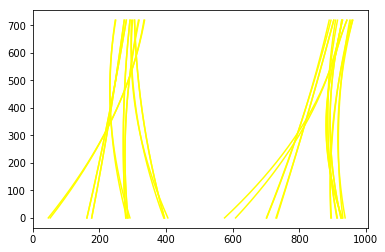

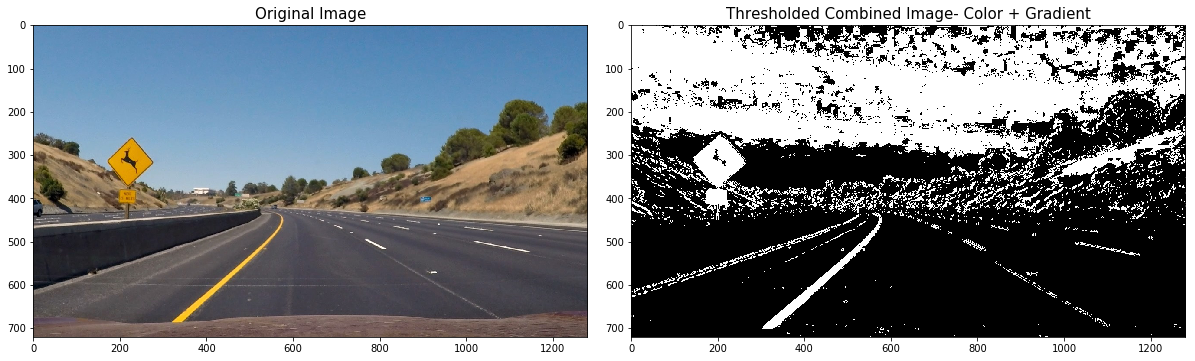

In [250]:
# 1. Call the calibration camera function
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

# 2. take all images from the camera_cal folder to undistort
os.listdir("test_images/")
for filename in os.listdir("test_images/"):
    # 2.1 Reading files for folder test_images
    image = mpimg.imread("test_images/" + filename)
    # 2.2 call the undistort function
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    radius_pixel = np.copy(undistort_img)
    radius_m = np.copy(undistort_img)
    # 2.3 save all images to the folder test_undistort
    mpimg.imsave('./output_images/test_undistort/' + filename, undistort_img)
    # 2.4 call the perspective transform function
    top_down, perspective_M, Minv, src, dst = corners_unwarp(undistort_img)
    # 2.5 save all images to the folder test_images_unwarp
    mpimg.imsave('./output_images/test_images_unwarp/' + filename, top_down)
    # 2.6 call the sobel threshold function
    grad_binaryx = abs_sobel_thresh(undistort_img, orient='x', thresh_min=30, thresh_max=90, sobel_kernel=15)
    # 2.7 save all images to the folder test_images_sobel
    mpimg.imsave('./output_images/test_images_sobelx/' + filename, grad_binaryx)
    # 2.8 call the magnitude threshold function
    mag_binary = mag_thresh(undistort_img, sobel_kernel=9, mag_thresh=(30, 90))
    # 2.9 save all images to the folder test_images_magnitude_threshold
    mpimg.imsave('./output_images/test_images_magnitude_threshold/' + filename, mag_binary)
    # 2.10 call the direction threshold function
    dir_binary = dir_threshold(undistort_img, sobel_kernel=15, thresh=(0.7, 1.3))
    # 2.11 save all images to the folder test_images_direction_threshold
    mpimg.imsave('./output_images/test_images_direction_threshold/' + filename, dir_binary)
    # 2.12 call the sobel threshold function
    grad_binaryy = abs_sobel_thresh(undistort_img, orient='y', thresh_min=30, thresh_max=90, sobel_kernel=15)
    # 2.13 save all images to the folder test_images_sobel
    mpimg.imsave('./output_images/test_images_sobely/' + filename, grad_binaryy)
    # 2.14 call the HSL Color threshold function
    hls_binary_s, hls_binary_l, hls_binary_h = hls_select(undistort_img, thresh=(100, 255))
    # 2.15 save all images to the folders test_images_s/l/h_channel
    mpimg.imsave('./output_images/test_images_s_channel/' + filename, hls_binary_s)
    mpimg.imsave('./output_images/test_images_l_channel/' + filename, hls_binary_l)
    mpimg.imsave('./output_images/test_images_h_channel/' + filename, hls_binary_h)
    # 2.16 call gthe HSV Color hreshold function
    hsv_binary_v = hsv_select(undistort_img, thresh=(100, 255))
    # 2.17 save all images to the folders test_images_s/l/h_channel
    mpimg.imsave('./output_images/test_images_v_channel/' + filename, hsv_binary_v)
    # 2.16 combining all the thresholds - color and gradient
    combined = np.zeros_like(dir_binary)
    #combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1)] = 1
    combined[(grad_binaryx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
    #2.17 save all images to the folder test_images_combined_threshold
    mpimg.imsave('./output_images/test_images_combined_threshold/' + filename, combined) 
    # 2.18 call the perspective transform function
    top_down1, perspective_M, Minv, src, dst = corners_unwarp(combined)
    # 2.19 save all images to the folder test_images_birdeyeview
    mpimg.imsave('./output_images/test_images_birdeye/' + filename, top_down1)
    # 2.20 call the Silidng Window function
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(top_down1)
    # 2.21 save all images to the folder test_images_birdeyeview
    mpimg.imsave('./output_images/test_images_sliding_window/' + filename, out_img)
    # 2.22 call the Search around poly function
    search_img, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(top_down1, left_fit, right_fit)
    # 2.23 save all images to the folder test_images_birdeyeview
    mpimg.imsave('./output_images/test_images_search_poly/' + filename, search_img)
    # 2.24 call the Curvature radius in pixel values
    left_curverad, right_curverad, car_location_pixel = measure_curvature_pixels(ploty, left_fit, right_fit)
    cv2.putText(radius_pixel,'Radius of left curvature :'+ str("%.2f" % round(left_curverad,2)) + 'pixels',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
    cv2.putText(radius_pixel,'Radius of right curvature :'+ str("%.2f" % round(right_curverad,2)) + 'pixels',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 
    # 2.25 save all images to the folder test_images_radius_pixel
    mpimg.imsave('./output_images/test_images_radius_pixel/' + filename, radius_pixel)
    # 2.26 call the Curvature radius in meters values
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad_m, right_curverad_m, off_center= measure_curvature_realm(top_down1,ym_per_pix, xm_per_pix, left_fit, right_fit)
    curverad=(left_curverad_m + right_curverad_m)/2
    cv2.putText(radius_m,'Radius of left curvature :'+ str("%.2f" % round(left_curverad_m,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
    cv2.putText(radius_m,'Radius of right curvature :'+ str("%.2f" % round(right_curverad_m,2)) + 'm',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 
    cv2.putText(radius_m,'Radius curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText3,font1,fontScale1,fontColor1,lineType1)
    
    if off_center < 0 :
        cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the right of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center > 0 :
        cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the left of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center == 0 :
        cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm on the center lane',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    # 2.28 save all images to the folder test_images_radius_meters
    mpimg.imsave('./output_images/test_images_radius_meters/' + filename, radius_m)
    # 2.29 Create final output images
    # 2.29.1 Create an image to draw on and an image to show the selection window
    visual_img1 = np.uint8(np.dstack((top_down1, top_down1, top_down1))*255)
    visual_img2 = np.zeros_like(visual_img1)
    # 2.29.2 Generate a polygon to illustrate the search window area And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    # 2.29.3 Draw the lane onto the warped blank image
    cv2.fillPoly(visual_img2, np.int_([line_pts]), (0,255, 0))
    visual_img3 = cv2.addWeighted(visual_img1, 1, visual_img2, 0.3, 0)
    # 2.29.4 UnWarp the blank back to original image space using inverse perspective matrix (Minv)
    Unwarp_img = cv2.warpPerspective(visual_img2, Minv, (undistort_img.shape[1], undistort_img.shape[0])) 
    # 2.29.5 Combine the result with the original image
    Final_Image = cv2.addWeighted(radius_m, 1, Unwarp_img, 0.3, 0)
    # 2.30 save all images to the folder output_images
    mpimg.imsave('./output_images/output_images/' + filename, Final_Image)
    
    
    
#print(top_down1.shape)    
# 3 Plot the final result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Combined Image- Color + Gradient', fontsize=15)
#ax3.imshow(top_down, cmap='gray')
#ax3.set_title('Warped Image', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.imshow(out_img)

## Perspective View of Image Check - To do for creating M and Minv matrix
## This step is required to be ran before running the Image and Video pipeline

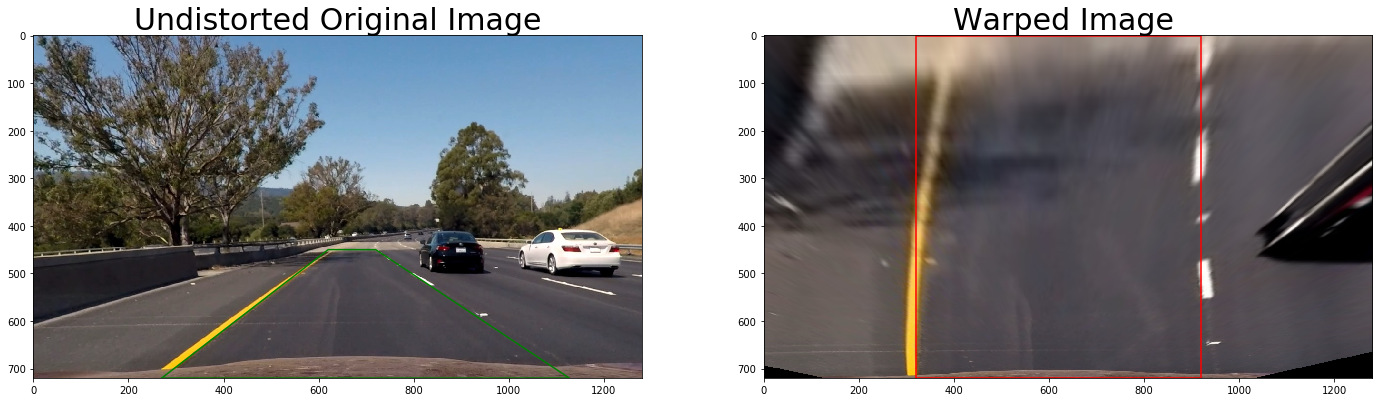

In [251]:
# 2.1 Reading files for folder test_images
image = mpimg.imread('./test_images/test6.jpg')#6

# 2.2 call the undistort function
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)

# 2.4 call the perspective transform function
top_down, perspective_M, Minv, src, dst = corners_unwarp(undistort_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.set_title('Undistorted Original Image', fontsize=30)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='green')
ax1.imshow(undistort_img)
ax2.set_title('Warped Image ', fontsize=30)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(top_down)

## Dump perspective matrix and inverse matrix in pickle for later use

In [252]:
pickle.dump(perspective_M, open( "M.p", "wb" ))
pickle.dump(Minv, open( "Minv.p", "wb" ))

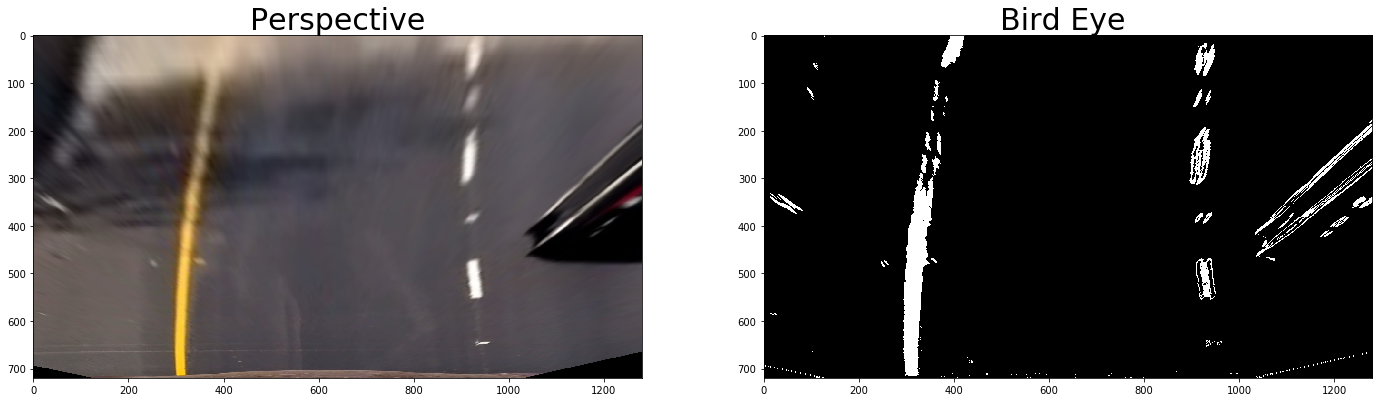

In [222]:
# 2.6 call the sobel threshold function
grad_binaryx = abs_sobel_thresh(top_down, orient='x', thresh_min=30, thresh_max=80, sobel_kernel=15)#30 90

# 2.8 call the magnitude threshold function
mag_binary = mag_thresh(top_down, sobel_kernel=9, mag_thresh=(30, 80))

# 2.10 call the direction threshold function
dir_binary = dir_threshold(top_down, sobel_kernel=15, thresh=(0.7, 1.3))

# 2.12 call the sobel threshold function
grad_binaryy = abs_sobel_thresh(top_down, orient='y', thresh_min=30, thresh_max=80, sobel_kernel=15)

# 2.14 call the HSL Color threshold function
hls_binary_s, hls_binary_l, hls_binary_h = hls_select(top_down, thresh=(100, 255))

# 2.15 call the HSV Color threshold function
hsv_binary_v = hsv_select(top_down, thresh=(100, 255))

# 2.16 combining all the thresholds - color and gradient
combined = np.zeros_like(hls_binary_s)
#combined[(hls_binary_s == 1)] = 1
#combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
combined[(grad_binaryx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.set_title('Perspective', fontsize=30)
ax1.imshow(top_down)
ax2.set_title('Bird Eye ', fontsize=30)
ax2.imshow(combined, cmap ='gray')

## Histogram of Image Check

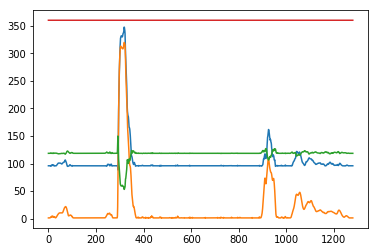

In [21]:
# 1.1 Reading files for folder test_images
image1 = mpimg.imread('./output_images/test_images_birdeye/test6.jpg')/255
# 1.2 call the histogram function
histogram = hist(image1)
    

# 1.3 Plot the final result
plt.plot(histogram)

plt.figure(figsize=(24,9))

## Running the Pipeline on an Image

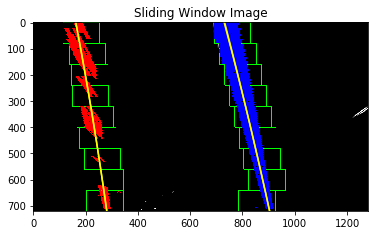

In [238]:
# 2.1 Reading files for folder test_images
image = mpimg.imread('./test_images/straight_lines2.jpg')

# 2.2 call the undistort function
undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
radius_pixel = np.copy(undistort_img)
radius_m = np.copy(undistort_img)

# 2.6 call the sobel threshold function
grad_binaryx = abs_sobel_thresh(undistort_img, orient='x', thresh_min=30, thresh_max=90, sobel_kernel=15)

# 2.8 call the magnitude threshold function
mag_binary = mag_thresh(undistort_img, sobel_kernel=9, mag_thresh=(30, 90))

# 2.10 call the direction threshold function
dir_binary = dir_threshold(undistort_img, sobel_kernel=15, thresh=(0.7, 1.3))

# 2.12 call the sobel threshold function
grad_binaryy = abs_sobel_thresh(undistort_img, orient='y', thresh_min=30, thresh_max=90, sobel_kernel=15)

# 2.14 call the HSL Color threshold function
hls_binary_s, hls_binary_l, hls_binary_h = hls_select(undistort_img, thresh=(100, 255))

# 2.15 call the HSV Color threshold function
hsv_binary_v = hsv_select(undistort_img, thresh=(100, 255))

# 2.16 combining all the thresholds - color and gradient
combined = np.zeros_like(dir_binary)
#combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
combined[(grad_binaryx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
 # 2.18 call the perspective transform function
top_down1, perspective_M, Minv, src, dst = corners_unwarp(combined)

# 2.19 call the Silidng Window function
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(top_down1)

# 2.20 call the Search around poly function
search_img, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(top_down1, left_fit, right_fit)

# 2.21 call the Curvature radius in pixel values
left_curverad, right_curverad, car_location_pixel = measure_curvature_pixels(ploty, left_fit, right_fit)
cv2.putText(radius_pixel,'Radius of left curvature :'+ str("%.2f" % round(left_curverad,2)) + 'pixels',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
cv2.putText(radius_pixel,'Radius of right curvature :'+ str("%.2f" % round(right_curverad,2)) + 'pixels',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 

# 2.22 call the Curvature radius in meters values
# 2.22.1 Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# 2.22.2 Calculate the radius of curvature in meters for both lane lines
left_curverad_m, right_curverad_m, off_center= measure_curvature_realm(top_down1,ym_per_pix, xm_per_pix, left_fit,right_fit)
curverad=(left_curverad_m + right_curverad_m)/2
cv2.putText(radius_m,'Radius of left curvature :'+ str("%.2f" % round(left_curverad_m,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
cv2.putText(radius_m,'Radius of right curvature :'+ str("%.2f" % round(right_curverad_m,2)) + 'm',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 
cv2.putText(radius_m,'Radius curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText3,font1,fontScale1,fontColor1,lineType1)


if off_center < 0 :
    cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the right of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
if off_center > 0 :
    cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the left of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
if off_center == 0 :
    cv2.putText(radius_m,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm on the center lane',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)

    
plt.imshow(out_img)
plt.title('Sliding Window Image')
plt.figure(figsize=(24,9))

## Warping the boundaries of the image

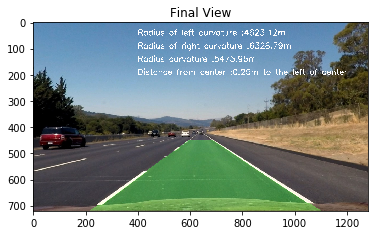

In [239]:
## Visualization ##
# Create an image to draw on and an image to show the selection window
visual_img1 = np.uint8(np.dstack((top_down1, top_down1, top_down1))*255)
visual_img2 = np.zeros_like(visual_img1)
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
line_pts = np.hstack((left_line_window, right_line_window))
# Draw the lane onto the warped blank image
cv2.fillPoly(visual_img2, np.int_([line_pts]), (0,255, 0))
visual_img3 = cv2.addWeighted(visual_img1, 1, visual_img2, 0.3, 0)

# UnWarp the blank back to original image space using inverse perspective matrix (Minv)
Unwarp_img = cv2.warpPerspective(visual_img2, Minv, (undistort_img.shape[1], undistort_img.shape[0])) 
# Combine the result with the original image
Final_Image = cv2.addWeighted(radius_m, 1, Unwarp_img, 0.3, 0)

plt.imshow(Final_Image)
plt.title('Final View')
plt.figure(figsize=(24,9))

## Visualizing the whole Pipeline on an Test Image

### Step 1 Original Image

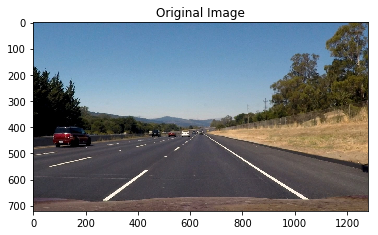

In [240]:
plt.imshow(image)
plt.title('Original Image')
plt.figure(figsize=(24,9))

### Step 2 Undistorted Image

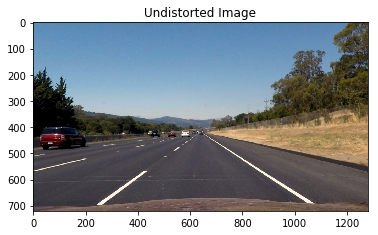

In [241]:
plt.imshow(undistort_img)
plt.title('Undistorted Image')
plt.figure(figsize=(24,9))

### Step 3 Thresholded Image

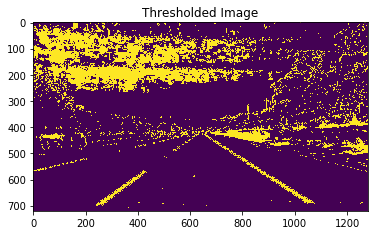

In [242]:
plt.imshow(combined)
plt.title('Thresholded Image')
plt.figure(figsize=(24,9))

### Step 4 Bird- Eye View Image

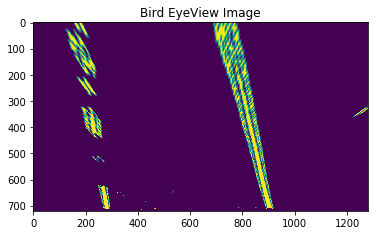

In [243]:
plt.imshow(top_down1)
plt.title('Bird EyeView Image')
plt.figure(figsize=(24,9))

### Step 5 Sliding Window View Image

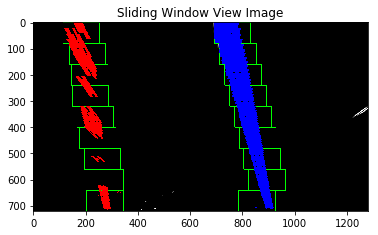

In [244]:
plt.imshow(out_img)
plt.title('Sliding Window View Image')
plt.figure(figsize=(24,9))

### Step 6 Search Around Poly Image

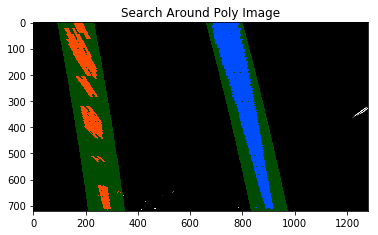

In [245]:
plt.imshow(search_img)
plt.title('Search Around Poly Image')
plt.figure(figsize=(24,9))

### Step 7 View Curvature Radius in pixel on Image

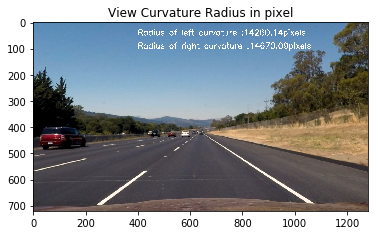

In [246]:
plt.imshow(radius_pixel)
plt.title('View Curvature Radius in pixel')
plt.figure(figsize=(24,9))

### Step 8 View Curvature Radius and Offset from Center in meters on Image

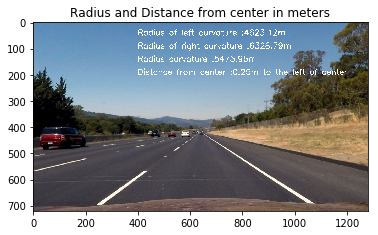

In [247]:
plt.imshow(radius_m)
plt.title('Radius and Distance from center in meters')
plt.figure(figsize=(24,9))

### Step 9 Final Output Image

(720, 1280, 3)


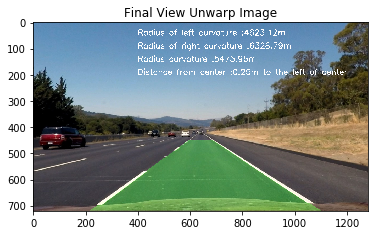

In [248]:
plt.imshow(Final_Image)
plt.title('Final View Unwarp Image')
plt.figure(figsize=(24,9))
print(Final_Image.shape)

## Step 10 Overlaying of Images over Final Image

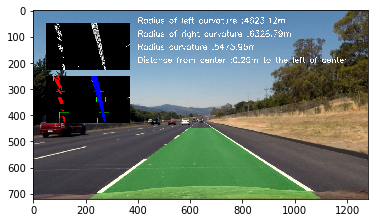

In [249]:
result = np.copy(Final_Image)
topdown = np.dstack((top_down1,top_down1,top_down1))*255
xpos = 50
ypos = 50

topdown_resize = cv2.resize(topdown, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
result[ypos:ypos+topdown_resize.shape[0],xpos:xpos+topdown_resize.shape[1]] = topdown_resize

xpos1 = 50
ypos1 = 250

out_img_resize = cv2.resize(out_img, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
result[ypos1:ypos1+out_img_resize.shape[0],xpos1:xpos1+out_img_resize.shape[1]] = out_img_resize

plt.imshow(result)

## Import Test Video

In [253]:
# Import everything needed to edit/save/watch video clips
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [254]:
# declare array and variables to store the previous frames (depending on frame counts defined)
#left_fit, right_fit and mean of left_fit and right_fit
prev_left_fit=[]
prev_right_fit=[]
sum_left_fit=0
sum_right_fit=0

## METHOD 1

In [255]:
def search_around_poly_1(binary_warped, left_fit, right_fit, frame_count = 10, average = True):
    
    #global fit_prev_left
    #global fit_prev_right
    #global fit_sum_left
    #global fit_sum_right
    
    global prev_left_fit
    global prev_right_fit
    global sum_left_fit
    global sum_right_fit

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60#50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
               
        
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

        
    # take average    
    if(average):
        if(len(prev_left_fit)>frame_count): # if the count of left_fit values stored in teh array are > frame count defined
            sum_left_fit= sum_left_fit - prev_left_fit.pop(0) # remove the first element - FIFO from total sum of left_fit values
            sum_right_fit= sum_right_fit - prev_right_fit.pop(0) # remove the first element - FIFO from total sum of right_fit values
        prev_left_fit.append(left_fit) #append the list with new left_fit value till frame count <= 10
        prev_right_fit.append(right_fit) #append the list with new right_fit valuetill frame count <= 10
        sum_left_fit =sum_left_fit + left_fit # adding the values
        sum_right_fit = sum_right_fit + right_fit # adding the values
        # caluclate the mean
        no_of_fit=len(prev_left_fit) 
        left_fit= sum_left_fit/no_of_fit
        right_fit= sum_right_fit/no_of_fit
        
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]#pixel points
    out_img[righty, rightx] = [0, 0, 255]#pixel points

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

In [256]:
def find_lane_pixels_1(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60#50
    # Set minimum number of pixels found to recenter window
    minpix = 60#50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_1(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

## Complete Pipeline for Video

In [257]:
first_run = 0

def ProcessImage(img):
    global first_run

    #load from pickle
    mtx = pickle.load( open( "mtx.p", "rb" ) )
    dist = pickle.load( open( "dist.p", "rb" ) )
    M = pickle.load( open( "M.p", "rb" ) )
    Minv = pickle.load( open( "Minv.p", "rb" ) )
    
    # Undistord image
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)

    # call the sobel threshold function
    grad_binaryx = abs_sobel_thresh(undistort_img, orient='x', thresh_min=30, thresh_max=80, sobel_kernel=15)

    # call the magnitude threshold function
    mag_binary = mag_thresh(undistort_img, sobel_kernel=9, mag_thresh=(30, 80))

    # call the direction threshold function
    dir_binary = dir_threshold(undistort_img, sobel_kernel=15, thresh=(0.7, 1.3))

    # call the sobel threshold function
    grad_binaryy = abs_sobel_thresh(undistort_img, orient='y', thresh_min=30, thresh_max=80, sobel_kernel=15)

    # call the HSL Color threshold function
    hls_binary_s, hls_binary_l, hls_binary_h = hls_select(undistort_img, thresh=(100, 255))
    
    # 2.15 call the HSV Color threshold function
    hsv_binary_v = hsv_select(undistort_img, thresh=(100, 255))

    # combining all the thresholds - color and gradient
    combined = np.zeros_like(dir_binary)
    #combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hls_binary_l == 1)] = 1
    #combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1)] = 1
    combined[(grad_binaryx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
    
    #load from pickle
    combined_size = (combined.shape[1], combined.shape[0])
    # use cv2.warpPerspective() to warp your image to a top-down view
    top_down1 = cv2.warpPerspective(combined, M, combined_size, flags=cv2.INTER_LINEAR)
        
    # if first frame always do sliding window approach
    if first_run == 0:        
          # 2.19 call the Silidng Window function
        out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial_1(top_down1)
        
    else:
        #load from pickle
        left_fit = pickle.load( open( "left_fit.p", "rb" ) )
        right_fit = pickle.load( open( "right_fit.p", "rb" ) )
        # check is left_fit and right_fit are detected in last frame :
        if len(left_fit)==0 or len(right_fit)==0:
            # 2.19 call the Silidng Window function
            out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial_1(top_down1)
        else:
            # 2.20 call the Search around poly function 
            #change frame_count values for averaging =6/4/10
            out_img, ploty, left_fit, right_fit, left_fitx, right_fitx  = search_around_poly_1(top_down1, left_fit, right_fit, frame_count = 10, average = True)
                  
    # 2.22 call the Curvature radius in meters values
    # 2.22.1 Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # 2.22.2 Calculate the radius of curvature in meters for both lane lines and diatnce from center
    left_curverad_m, right_curverad_m, off_center= measure_curvature_realm(top_down1,ym_per_pix, xm_per_pix, left_fit, right_fit)
    curverad=(left_curverad_m + right_curverad_m)/2
        
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    visual_img1 = np.zeros_like(top_down1)
    visual_img2 = np.uint8(np.dstack((visual_img1, visual_img1, visual_img1))*255)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(visual_img2, np.int_([line_pts]), (0,255, 0))
    
    # UnWarp the blank back to original image space using inverse perspective matrix (Minv)
    Unwarp_img = cv2.warpPerspective(visual_img2, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    Final_Image1 = cv2.addWeighted(img, 1, Unwarp_img, 0.3, 0)

    cv2.putText(Final_Image1,'Radius of left curvature :'+ str("%.2f" % round(left_curverad_m,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
    cv2.putText(Final_Image1,'Radius of right curvature :'+ str("%.2f" % round(right_curverad_m,2)) + 'm',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 
    cv2.putText(Final_Image1,'Radius curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText3,font1,fontScale1,fontColor1,lineType1)
    if off_center < 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the right of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center > 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the left of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center == 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm on the center lane',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    
    # Overlaying of images
    result = Final_Image1
    topdown = np.dstack((top_down1,top_down1,top_down1))*255
    xpos = 50
    ypos = 50

    topdown_resize = cv2.resize(topdown, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
    result[ypos:ypos+topdown_resize.shape[0],xpos:xpos+topdown_resize.shape[1]] = topdown_resize

    xpos1 = 50
    ypos1 = 250

    out_img_resize = cv2.resize(out_img, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
    result[ypos1:ypos1+out_img_resize.shape[0],xpos1:xpos1+out_img_resize.shape[1]] = out_img_resize
    
    # Save points
    pickle.dump(left_fit, open( "left_fit.p", "wb" ))
    pickle.dump(right_fit, open( "right_fit.p", "wb" ))
    
    first_run = first_run + 1
   
    return result

## Input Test Video 1

[MoviePy] >>>> Building video project_video_output1.mp4
[MoviePy] Writing video project_video_output1.mp4


100%|█████████▉| 1260/1261 [10:05<00:00,  2.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output1.mp4 

CPU times: user 7min 2s, sys: 1min 1s, total: 8min 3s
Wall time: 10min 8s


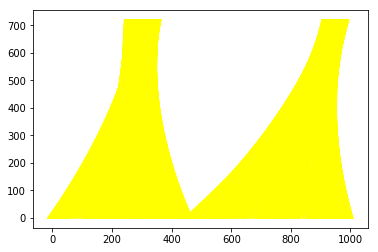

In [258]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(1,5)
clip1 = VideoFileClip("project_video.mp4")
Project_clip = clip1.fl_image(ProcessImage) #NOTE: this function expects color images!!
%time Project_clip.write_videofile('project_video_output1.mp4', audio=False)

## Visualize Test Video 1

In [259]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output1.mp4'))

# METHOD 2

## Finding Lane Lines - 2

In [185]:
prev_left_fit=[]
prev_right_fit=[]
sum_left_fit=0
sum_right_fit=0

In [186]:
def find_lanes_v(binary_warped, frame_count=10, average = True ):
    
    global prev_left_fit
    global prev_right_fit
    global sum_left_fit
    global sum_right_fit
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60#70
    # Set minimum number of pixels found to recenter window
    minpix = 60#70

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(average):
        if(len(prev_left_fit)>frame_count):
            sum_left_fit= sum_left_fit - prev_left_fit.pop(0)
            sum_right_fit= sum_right_fit - prev_right_fit.pop(0)

        prev_left_fit.append(left_fit)
        prev_right_fit.append(right_fit)
        sum_left_fit =sum_left_fit + left_fit
        sum_right_fit = sum_right_fit + right_fit

        no_of_fit=len(prev_left_fit) 
        left_fit= sum_left_fit/no_of_fit
        right_fit= sum_right_fit/no_of_fit
        
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]#pixel points
    out_img[righty, rightx] = [0, 0, 255]#pixel points

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

## Video Pipeline - 2

In [187]:
def ProcessImage_v(img):

    #load from pickle
    mtx = pickle.load( open( "mtx.p", "rb" ) )
    dist = pickle.load( open( "dist.p", "rb" ) )
    M = pickle.load( open( "M.p", "rb" ) )
    Minv = pickle.load( open( "Minv.p", "rb" ) )
    
    # Undistord image
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)

    # call the sobel threshold function
    grad_binaryx = abs_sobel_thresh(undistort_img, orient='x', thresh_min=30, thresh_max=80, sobel_kernel=15)#15 # 30 90

    # call the magnitude threshold function
    mag_binary = mag_thresh(undistort_img, sobel_kernel=9, mag_thresh=(30, 80))#9 # 30,90

    # call the direction threshold function
    dir_binary = dir_threshold(undistort_img, sobel_kernel=15, thresh=(0.7, 1.3))#15 

    # call the sobel threshold function
    grad_binaryy = abs_sobel_thresh(undistort_img, orient='y', thresh_min=30, thresh_max=80, sobel_kernel=15)#15

    # call the HSL Color threshold function
    hls_binary_s, hls_binary_l, hls_binary_h = hls_select(undistort_img, thresh=(100, 255))
    
    # 2.15 call the HSV Color threshold function
    hsv_binary_v = hsv_select(undistort_img, thresh=(100, 255))

    # combining all the thresholds - color and gradient
    combined = np.zeros_like(dir_binary)
    #combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hls_binary_l == 1)] = 1
    #combined[((grad_binaryx == 1) & (grad_binaryy == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1)] = 1
    combined[(grad_binaryx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary_s == 1) & (hsv_binary_v == 1)] = 1
    
    #load from pickle
    combined_size = (combined.shape[1], combined.shape[0])
    # use cv2.warpPerspective() to warp your image to a top-down view
    top_down1 = cv2.warpPerspective(combined, M, combined_size, flags=cv2.INTER_LINEAR)
        

    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx  = find_lanes_v(top_down1, frame_count = 10, average = True)
                  
    # 2.22 call the Curvature radius in meters values
    # 2.22.1 Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # 2.22.2 Calculate the radius of curvature in meters for both lane lines and diatnce from center
    left_curverad_m, right_curverad_m, off_center= measure_curvature_realm(top_down1,ym_per_pix, xm_per_pix, left_fit, right_fit)
    curverad=(left_curverad_m + right_curverad_m)/2
        
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    visual_img1 = np.zeros_like(top_down1)
    visual_img2 = np.uint8(np.dstack((visual_img1, visual_img1, visual_img1))*255)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(visual_img2, np.int_([line_pts]), (0,255, 0))
    
    # UnWarp the blank back to original image space using inverse perspective matrix (Minv)
    Unwarp_img = cv2.warpPerspective(visual_img2, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    Final_Image1 = cv2.addWeighted(img, 1, Unwarp_img, 0.3, 0)

    cv2.putText(Final_Image1,'Radius of left curvature :'+ str("%.2f" % round(left_curverad_m,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
    cv2.putText(Final_Image1,'Radius of right curvature :'+ str("%.2f" % round(right_curverad_m,2)) + 'm',bottomLeftCornerOfText2,font1,fontScale1,fontColor1,lineType1) 
    cv2.putText(Final_Image1,'Radius curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText3,font1,fontScale1,fontColor1,lineType1)
    if off_center < 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the right of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center > 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm to the left of center',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    if off_center == 0 :
        cv2.putText(Final_Image1,'Distance from center :'+ str("%.2f" % round(off_center,4)) + 'm on the center lane',bottomLeftCornerOfText4,font1,fontScale1,fontColor1,lineType1)
    
    # Overlaying of images
    result = Final_Image1
    topdown = np.dstack((top_down1,top_down1,top_down1))*255
    xpos = 50
    ypos = 50

    topdown_resize = cv2.resize(topdown, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
    result[ypos:ypos+topdown_resize.shape[0],xpos:xpos+topdown_resize.shape[1]] = topdown_resize

    xpos1 = 50
    ypos1 = 250

    out_img_resize = cv2.resize(out_img, None, fx = 0.25, fy = 0.25, interpolation = cv2.INTER_CUBIC)
    result[ypos1:ypos1+out_img_resize.shape[0],xpos1:xpos1+out_img_resize.shape[1]] = out_img_resize
    
    # Save points
    pickle.dump(left_fit, open( "left_fit.p", "wb" ))
    pickle.dump(right_fit, open( "right_fit.p", "wb" ))
    
   
    return result

## Input Video - 2

[MoviePy] >>>> Building video project_video_output_v.mp4
[MoviePy] Writing video project_video_output_v.mp4


100%|█████████▉| 1260/1261 [10:43<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_v.mp4 

CPU times: user 7min 25s, sys: 1min 15s, total: 8min 41s
Wall time: 10min 46s


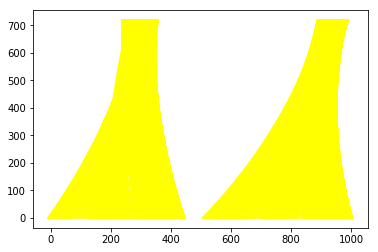

In [188]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(1,5)
clip1 = VideoFileClip("project_video.mp4")
Project_clip = clip1.fl_image(ProcessImage_v) #NOTE: this function expects color images!!
%time Project_clip.write_videofile('project_video_output_v.mp4', audio=False)

## Visualize the output video - 2

In [189]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output_v.mp4'))